# Introduction - investigating the most popular data science questions

An investigational scenario, where I explore the most popular data science questions by scouring Stack Exchange.

**Scenario:** Working for a fictional company that creates data science content such as online articles and videos. They require new material and would like to know what content is the "best" to write about. After discussions, you decide to focus on the following question: "What is it that people want to learn about in data science?". The basis of your investigation will be to consult Stack Exchange (Q&A website about programming) and see what content is more popular.

![image info](https://dq-content.s3.amazonaws.com/469/se_sites.png)

**Stack Exchange and accessing data**

One aspect of the website that will be very useful is the tags that are used to categorise content. 

Stack Exchange provides a public data base for each of its websites, which can be queried here: https://data.stackexchange.com/datascience/query/new

The relevant columns are:

- `Id:` An identification number for the post.
- `PostTypeId:` An identification number for the type of post.
- `CreationDate:` The date and time of creation of the post.
- `Score:` The post's score.
- `ViewCount:` How many times the post was viewed.
- `Tags:` What tags were used.
- `AnswerCount:` How many answers the question got (only applicable to question posts).
- `FavoriteCount:` How many times the question was favoured (only applicable to question posts).

**Query to get relevant data from Stack Exchagne data base**

The scenario takes place in 2020, and so I extract the full results filtered by the previous year (2019) and by the correct post type (post Id relates to questions):

```SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
  FROM posts
  WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;```
 

# Exploratory steps - getting familiar with the data

Aiming to answer the following questions:

- How many missing values are there in each column?
- Can we fix the missing values somehow?
- Are the types of each column adequate?
- What can we do about the Tags column?

In [1]:
#import libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

In [2]:
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [3]:
#read in data
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

In [4]:
#to make data exploration easier, condense it down into a few steps and create a function:

def explore(dataset):
    print(dataset.info())
    print(dataset.head())
    print(dataset.isnull()) #replace with sns heatmap at end

In [5]:
explore(questions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB
None
      Id        CreationDate  Score  ViewCount  \
0  44419 2019-01-23 09:21:13      1         21   
1  44420 2019-01-23 09:34:01      0         25   
2  44423 2019-01-23 09:58:41      2       1651   
3  44427 2019-01-23 10:57:09      0         55   
4  44428 2019-01-23 11:02:15      0         19   

                                              

In [6]:
questions['Tags']

0                         <machine-learning><data-mining>
1       <machine-learning><regression><linear-regressi...
2            <python><time-series><forecast><forecasting>
3                   <machine-learning><scikit-learn><pca>
4                <dataset><bigdata><data><speech-to-text>
                              ...                        
8834      <pca><dimensionality-reduction><linear-algebra>
8835                       <keras><weight-initialization>
8836                     <python><visualization><seaborn>
8837                                        <time-series>
8838                                               <k-nn>
Name: Tags, Length: 8839, dtype: object

### Observations 

- Only the favorite column has missing values. This column represents how many times the question was favourited, so probably means that it wasn't favourited
- Favorite column can be rectified by filling  with zeroes
- Tags column has 8839 unique entries - appears to be entry for all tags assigned for that post Id

The tags column will require cleaning. The maximum amount of tags seen from the above exploration is 5, therefore it would make sense to separate each tag into a separate column by tag 1 to tag 5.

# Data cleaning - fixing columns

1. Tags column requires reformatting; each tag is surrounded by < >, by replacing the > with , will allow me to separate them using string methods into tag 1 - tag 5
2. missing values in FavoriteCount tab needs to be filled in

In [7]:
#replace < and > as appropriate with comma
#rstrip included to remove the lagging comma
questions['Tags'] = questions['Tags'].str.replace("<", "").str.replace(">", ",").str.rstrip(',')

#split on ',' to create a list
questions['Tags'] = questions['Tags'].str.split(',')

In [8]:
questions['Tags'].head()

0                      [machine-learning, data-mining]
1    [machine-learning, regression, linear-regressi...
2         [python, time-series, forecast, forecasting]
3                [machine-learning, scikit-learn, pca]
4             [dataset, bigdata, data, speech-to-text]
Name: Tags, dtype: object

In [9]:
#fill in missing values as 0, then change type to integer
questions['FavoriteCount'] = questions['FavoriteCount'].fillna(0).astype(int)

In [10]:
#confirm data type change
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int32
dtype: object

In [11]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1,0
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0,0


# Data analysis - determining most popular tags

In order to determine the most popular tags, i'll consider (for each tag):

1. how many times the tag was used
2. how many times a question with that tag was viewed

In [12]:
#counting how many times each tag was used - using a dict approach

tags_total = {}

for tags in questions['Tags']: #to access each list I created previously from all the tags
    for i in tags: #to access each tag in the list
        if i in tags_total:
            tags_total[i] += 1
        else:
            tags_total[i] = 1
            

In [13]:
#sorting the dict in descending order
sorted(tags_total.items(), key=lambda x: x[1], reverse=True)

[('machine-learning', 2693),
 ('python', 1814),
 ('deep-learning', 1220),
 ('neural-network', 1055),
 ('keras', 935),
 ('classification', 685),
 ('tensorflow', 584),
 ('scikit-learn', 540),
 ('nlp', 493),
 ('cnn', 489),
 ('time-series', 466),
 ('lstm', 402),
 ('pandas', 354),
 ('regression', 347),
 ('dataset', 340),
 ('r', 268),
 ('predictive-modeling', 265),
 ('clustering', 257),
 ('statistics', 234),
 ('machine-learning-model', 224),
 ('data-mining', 217),
 ('data', 213),
 ('image-classification', 211),
 ('feature-selection', 209),
 ('reinforcement-learning', 203),
 ('data-science-model', 186),
 ('linear-regression', 175),
 ('pytorch', 175),
 ('xgboost', 165),
 ('feature-engineering', 163),
 ('loss-function', 161),
 ('random-forest', 159),
 ('data-cleaning', 157),
 ('logistic-regression', 154),
 ('rnn', 149),
 ('training', 148),
 ('decision-trees', 145),
 ('cross-validation', 139),
 ('svm', 136),
 ('multiclass-classification', 131),
 ('prediction', 128),
 ('visualization', 126),
 ('n

In [14]:
#however, would look better and easier to work with as a dataframe
tags_total_df = pd.DataFrame.from_dict(tags_total, orient="index")

#rename col to something more descriptive
tags_total_df.rename(columns={0: "tag_count"}, inplace=True)

In [15]:
#sort column values, descending
tags_total_df = tags_total_df.sort_values(by='tag_count', ascending=False)
most_used = tags_total_df[:20]

In [16]:
#plotly attempt - making a more interactive plot

import plotly.express as ex
import plotly

#creating plot
top_10 = most_used[:10]
ex.pie(top_10, values='tag_count',names=top_10.index,title='Top 10 tags')

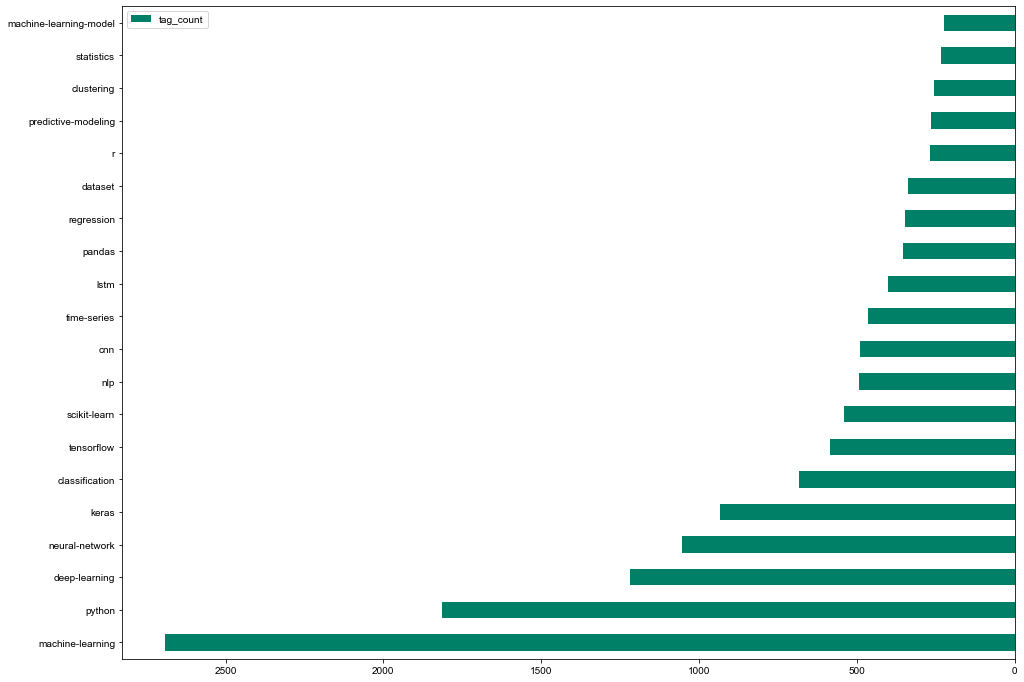

In [17]:
#basic bar chart
most_used.plot(kind="barh", cmap="summer", figsize=(16,12))
sns.set_style('white')
plt.gca().invert_xaxis()
plt.show()

<AxesSubplot:>

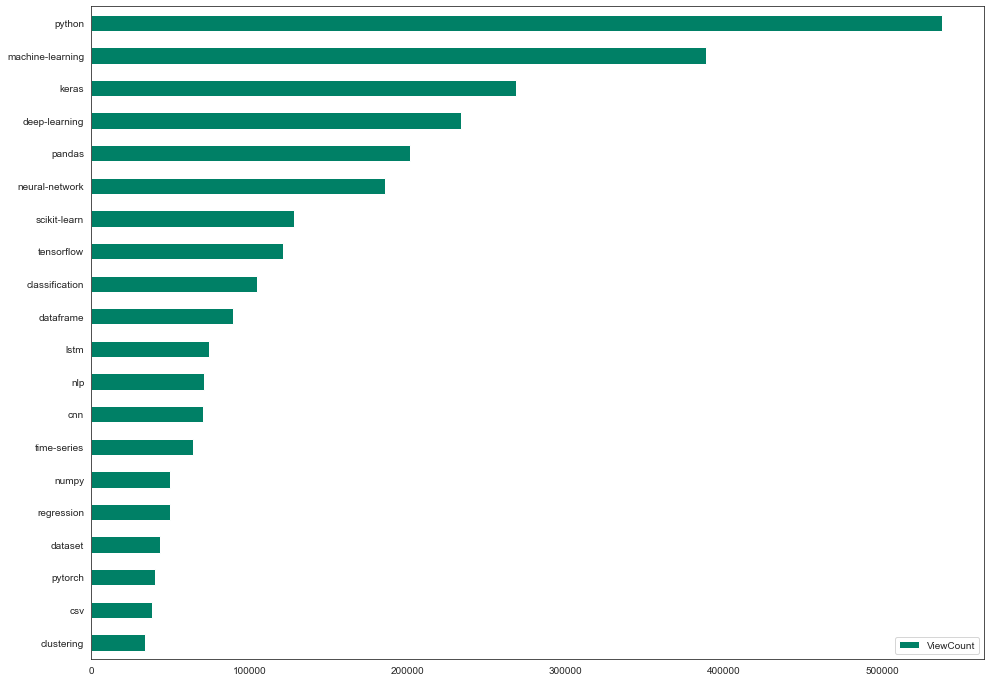

In [18]:
#calculating view count for each tag - understanding of below use of .interrows()
#iterrows() allows to iterate over df rows as (index, series) pairs (from documentation)
#row in the below for loop therefore refers to each index and row content pair e.g. (index 4, "post content")

#makes a frequency dict, key = tag, 

tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']: #iterates over each row's "tags" column within questions dataframe
        if tag in tag_view_count: 
            tag_view_count[tag] += row['ViewCount'] #if tag in tag_views, add to existing value in 'ViewCount' col
        else:
            tag_view_count[tag] = row['ViewCount'] #if tag not already in tag_views, assign that value into new, 'ViewCount'
            
#e.g. from the questions dataframe, the 'ViewCount' entries are all integer values to represent view count of the post
#for loop above iterates by index and row content, each entry in the 'Tags' col (it is a list, so accesses each tag inside)
#if tag isn't in the newly initialised (empty) dict, add the tag as a key, and assign the 'ViewCount' int value as it's value
# so key:value looks like tag:ViewCount
#if the key is already in the dict, add the integer value from ViewCount to the existing value within key:value pair

tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index") #convert dict to df
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)
sns.set_style('white')
most_viewed.plot(kind="barh", cmap="summer", figsize=(16,12))

# Data analysis - comparing most used and most viewed tags

**Recap**

the **most_used** df counts how many times each tag was used, and **most_viewed** counts how many times each of the tags was viewed.

Here i'll explore what tags are in most_used but not in most_viewed, and vice versa.

In [19]:
#tags in most_used but not in most_viewed
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)

In [20]:
in_used

,tag_count,ViewCount
machine-learning,2693,388499.0
python,1814,537585.0
deep-learning,1220,233628.0
neural-network,1055,185367.0
keras,935,268608.0
classification,685,104457.0
tensorflow,584,121369.0
scikit-learn,540,128110.0
nlp,493,71382.0
cnn,489,70349.0


In [21]:
#tags present in most_viewed but not in most_used
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)
in_viewed = in_viewed.sort_values(by='tag_count', ascending=False)

In [22]:
in_viewed

,tag_count,ViewCount
machine-learning,2693.0,388499
python,1814.0,537585
deep-learning,1220.0,233628
neural-network,1055.0,185367
keras,935.0,268608
classification,685.0,104457
tensorflow,584.0,121369
scikit-learn,540.0,128110
nlp,493.0,71382
cnn,489.0,70349


### Observations

**Tags present in most_used, not in most_viewed**
- machine-learning-model
- statistics
- predictive-modeling
- r

**Tags present in most_viewed, not in most_used**
- csv
- pytorch
- dataframe

There are some related tags. For example, python libraries such as pandas. We can infer that posts relating to pandas are also simultaneously related to python. 

In order to find unrelated tag pairs, I'll use the following:

```questions[questions["Tags"].apply(lambda tags: True if "name of tag" in tags and "name of tag" in tags else False)]```

In [23]:
#checking to see if a pandas library and r tags are paired

questions[questions["Tags"].apply(lambda tags: True if "r" in tags and "pandas" in tags else False)]

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
2873,60074,2019-09-11 20:35:17,0,22,"[r, pandas, dplyr]",0,0
3651,49148,2019-04-11 19:41:39,1,83,"[r, data-mining, pandas, matlab, databases]",3,0


# Data analysis - relationship between tag pairs

In order to understand how the different tags are related, I need an approach to count how many times each pair of tags appears together.

In [24]:
#first, extract a list of all tags from tags_total_df
all_tags = list(tags_total_df.index)

#convert to a df
associations = pd.DataFrame(index=all_tags, columns=all_tags)

In [25]:
associations 

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,...,marginal-effects,hurdle-model,least-squares-svm,proximal-svm,xboost,cs231n,statsmodels,rdkit,apache-nifi,kitti-dataset
machine-learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deep-learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neural-network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
keras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cs231n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statsmodels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rdkit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache-nifi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#to fill each entry with zeroes, to then increment based on occurence of pairs
associations.fillna(0, inplace=True)

#using df.loc[] to access rows and columns by label
#e.g. if table was in the form of row name A, col name A
#would produce a result table with A as row name, A as col name and value of 1
#therefore, below for loop accesses each tag in questions df
#then the associations.loc[tags, tags] targets each value that have the same row and column names 
#see structure of associations df above

#in essence, it loops through associations to count how many times each pair of tags appears together

for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1 #increment by one when each tag is paired

In [27]:
#this uses the index of most_used (which was limited to 20) to limit to top 20
relations_most_used = associations.loc[most_used.index, most_used.index]

In [28]:
#removes the identical pairs to prevent data skew
for i in range(0, 20):
    relations_most_used.iloc[i,i] = pd.np.NaN

C:\Users\44751\AppData\Local\Temp/ipykernel_46820/1292321873.py:3: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



C:\Users\44751\AppData\Local\Temp/ipykernel_46820/1002909711.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<AxesSubplot:>

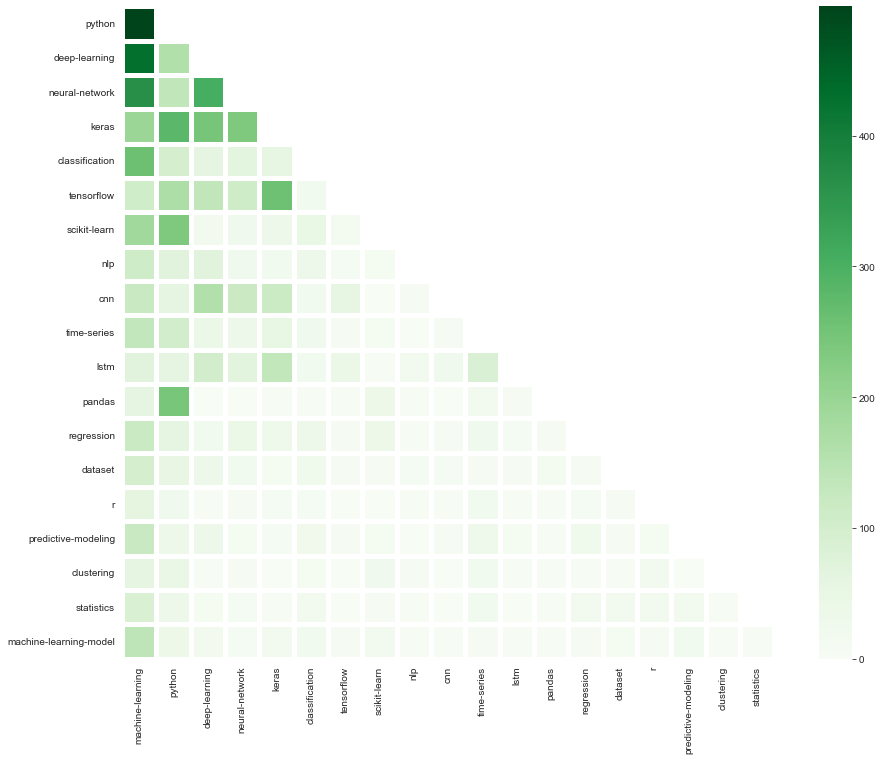

In [29]:
#define a mask to apply to heatmap - thanks to https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c
mask = np.triu(np.ones_like(relations_most_used, dtype=np.bool))
mask = mask[1:, :-1]
relations_most_used_heatmap = relations_most_used.iloc[1:,:-1].copy()


#create a heatmap
plt.figure(figsize=(16,12))
sns.set_style('white')
sns.heatmap(relations_most_used_heatmap, cmap="Greens", annot=False, square=True, mask = mask, linewidths=5)

### Observations

There is a trend where the most used tags seems to have the strongest relationship, as seen in the top left corner. Since I'm looking for candidates to answer the question "What is it that people want to learn about in data science?", `machine learning` would be a good choice. However, it is a very broad topic. `keras`, `scikitlearn` and `tensorflow` are also potential candidates and are all python libraries used in deep learning. Therefore, `deep learning` might be a good choice as there are many related tags that are used often.

Now, i'll investigate tag usage again by percentage.

### Another approach - relationship between tag pairs by percentage

In [30]:
#filter for where each tag is used > 100 times
popular_tags = tags_total_df[tags_total_df['tag_count'] > 100]
popular_list = list(popular_tags.index)

#uses associations df format to create a new df with only the tags with a usage > 100
popular_percent = associations.loc[popular_list, popular_list]

In [31]:
popular_percent

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,...,preprocessing,numpy,word-embeddings,text-mining,convnet,unsupervised-learning,object-detection,autoencoder,recommender-system,convolution
machine-learning,2693,499,429,366,195,259,106,188,113,124,...,36,24,24,27,27,49,24,21,41,28
python,499,1814,160,137,280,98,167,235,71,62,...,23,71,7,22,18,21,22,22,14,9
deep-learning,429,160,1220,305,247,59,136,16,72,160,...,10,10,12,10,43,9,36,32,10,43
neural-network,366,137,305,1055,235,65,108,24,24,118,...,8,11,10,2,25,11,10,35,7,34
keras,195,280,247,235,935,58,256,34,23,116,...,9,11,12,0,34,3,16,28,2,12
classification,259,98,59,65,58,685,20,47,35,20,...,7,4,6,13,3,4,6,1,5,4
tensorflow,106,167,136,108,256,20,584,15,11,57,...,3,13,7,1,11,0,21,10,3,9
scikit-learn,188,235,16,24,34,47,15,540,12,0,...,10,12,2,4,1,8,0,0,8,0
nlp,113,71,72,24,23,35,11,12,493,7,...,5,0,56,34,1,4,1,1,1,1
cnn,124,62,160,118,116,20,57,0,7,489,...,4,2,1,2,22,3,13,5,0,33


In [32]:
#by percentage, using df.div to work out percentages
tags_percent_total = popular_percent.merge(tags_total_df, how='left', left_index=True, right_index=True)
tags_percent_copy = tags_percent_total.div(tags_percent_total['tag_count'], axis=0)
tags_percent_copy

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,...,numpy,word-embeddings,text-mining,convnet,unsupervised-learning,object-detection,autoencoder,recommender-system,convolution,tag_count
machine-learning,1.000000,0.185295,0.159302,0.135908,0.072410,0.096175,0.039361,0.069811,0.041961,0.046045,...,0.008912,0.008912,0.010026,0.010026,0.018195,0.008912,0.007798,0.015225,0.010397,1.0
python,0.275083,1.000000,0.088203,0.075524,0.154355,0.054024,0.092062,0.129548,0.039140,0.034179,...,0.039140,0.003859,0.012128,0.009923,0.011577,0.012128,0.012128,0.007718,0.004961,1.0
deep-learning,0.351639,0.131148,1.000000,0.250000,0.202459,0.048361,0.111475,0.013115,0.059016,0.131148,...,0.008197,0.009836,0.008197,0.035246,0.007377,0.029508,0.026230,0.008197,0.035246,1.0
neural-network,0.346919,0.129858,0.289100,1.000000,0.222749,0.061611,0.102370,0.022749,0.022749,0.111848,...,0.010427,0.009479,0.001896,0.023697,0.010427,0.009479,0.033175,0.006635,0.032227,1.0
keras,0.208556,0.299465,0.264171,0.251337,1.000000,0.062032,0.273797,0.036364,0.024599,0.124064,...,0.011765,0.012834,0.000000,0.036364,0.003209,0.017112,0.029947,0.002139,0.012834,1.0
classification,0.378102,0.143066,0.086131,0.094891,0.084672,1.000000,0.029197,0.068613,0.051095,0.029197,...,0.005839,0.008759,0.018978,0.004380,0.005839,0.008759,0.001460,0.007299,0.005839,1.0
tensorflow,0.181507,0.285959,0.232877,0.184932,0.438356,0.034247,1.000000,0.025685,0.018836,0.097603,...,0.022260,0.011986,0.001712,0.018836,0.000000,0.035959,0.017123,0.005137,0.015411,1.0
scikit-learn,0.348148,0.435185,0.029630,0.044444,0.062963,0.087037,0.027778,1.000000,0.022222,0.000000,...,0.022222,0.003704,0.007407,0.001852,0.014815,0.000000,0.000000,0.014815,0.000000,1.0
nlp,0.229209,0.144016,0.146045,0.048682,0.046653,0.070994,0.022312,0.024341,1.000000,0.014199,...,0.000000,0.113590,0.068966,0.002028,0.008114,0.002028,0.002028,0.002028,0.002028,1.0
cnn,0.253579,0.126789,0.327198,0.241309,0.237219,0.040900,0.116564,0.000000,0.014315,1.000000,...,0.004090,0.002045,0.004090,0.044990,0.006135,0.026585,0.010225,0.000000,0.067485,1.0


In [33]:
#to examine association between two tags, create heat map

for i in range(len(popular_list)):
    tags_percent_copy.iloc[i,i] = pd.np.NAN #where tags match, remove
    
tags_percent_copy.drop('tag_count', axis=1, inplace=True)

#filter by those with > 25% association
popular_percent_25 = tags_percent_copy[tags_percent_copy >.25].dropna(how='all').dropna(how='all', axis=1)

C:\Users\44751\AppData\Local\Temp/ipykernel_46820/241389328.py:4: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



<AxesSubplot:>

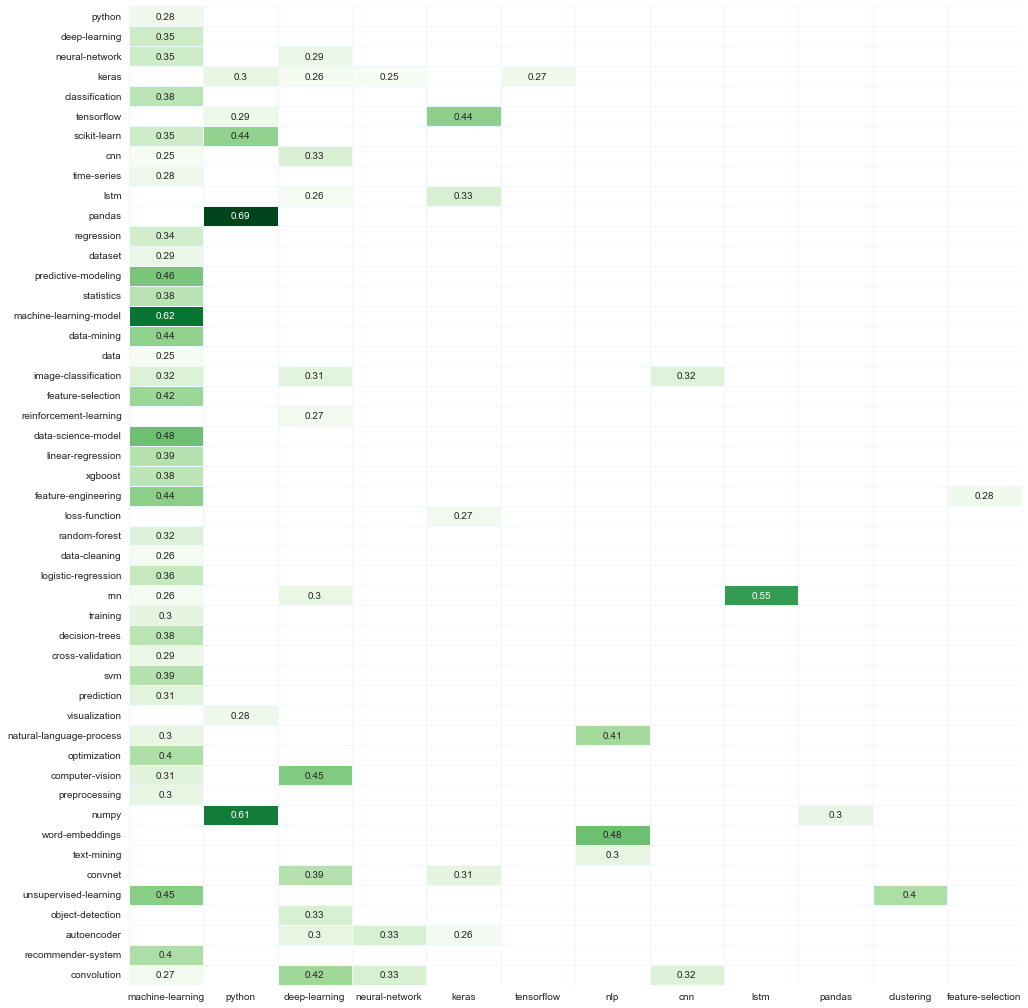

In [34]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(16,18))
sns.heatmap(popular_percent_25, cmap='Greens', annot=True, linewidths=1, cbar=False, linecolor='aliceblue')

### Observations
- as expected, python libraries are often used with the python tag, e.g. `pandas` at 69% and `numpy` with 61%
- many machine learning-related tags have high usage along with the `machine-learning` tag, e.g. `data-mining` at 44%

This is a useful piece of analysis as, for our objective, it allows me to select related sub-topics to our chosen topic. If I wanted to produce a series of content on machine learning for example, I could section it based on popular related sub-topics such as data mining or feature engineering. 

# Data analysis - digging deeper into Deep Learning

My chosen topic, `deep learning` was one of the most popular topics based on my analysis. However, this data relates solely to the year 2019. Therefore, if it was only popular in that year alone, it may not be a good candidate for future content. 

**"Is deep learning just a fad?"**

I want content that will be useful and relevant for today's audience, so the next step of my analysis will be to investigate the tag's popularity across years. 

Provided by the scenario is `all_questions.csv`, which holds the results of:

`SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;` 
 
 from the StackExchange public data base. This result fetches **all** questions ever asked on the data science stack exchange, with their dates and tags. This will allow me to track the interest in deep learning across time, by doing:
 
 1. counting how many deep learning questions are asked per time period
 2. total amount of questions per time period
 3. how many deep learning questions there are relative to the total amount of questions per time period

In [35]:
# reading in csv
all_questions = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

In [36]:
all_questions.sample(10)

,Id,CreationDate,Tags
6216,17539,2017-03-12 18:03:54,<machine-learning><neural-network><svm><decisi...
10313,50944,2019-04-25 21:28:20,<orange><unbalanced-classes>
14240,52512,2019-05-24 07:03:04,<machine-learning><data><error-handling>
8996,41378,2018-11-18 13:00:45,<time-series><cross-validation><ensemble-learn...
14851,52809,2019-05-29 07:22:50,<machine-learning>
15824,53246,2019-06-05 11:33:58,<autoencoder><feature-scaling><outlier>
12612,30356,2018-04-16 01:21:22,<pandas><preprocessing>
7907,58768,2019-09-06 07:03:09,<predictive-modeling><random-forest><machine-l...
2307,902,2014-08-04 19:10:57,<machine-learning><data-mining><statistics><se...
19724,33861,2018-07-02 04:11:31,<machine-learning><keras><lstm>


In [37]:
#clean Tags column as before

all_questions['Tags'] = all_questions['Tags'].str.replace("<", "").str.replace(">", ",").str.rstrip(',')

#split on ',' to create a list
all_questions['Tags'] = all_questions['Tags'].str.split(',')

In [38]:
all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


Now I must decide on which tags are classified as 'deep learning'. I'll focus on the most popular tags that appeared closely associated with deep learning, as from research, they are related subtopics.

In [39]:
dl_list = ['deep-learning', 'keras', 'neural-network', 'cnn', 'convolution', 'tensor-flow', 'scikit-learn']

#using a df.apply() approach to classify each post as deep learning or not
def deep(tags):
    for tag in tags:
        if tag in dl_list:
            return 1
    else:
        return 0

all_questions['Deep_Learning'] = all_questions['Tags'].apply(deep)

In [40]:
all_questions.head()

,Id,CreationDate,Tags,Deep_Learning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


In [41]:
# Extract year to separate column
all_questions['Year'] = all_questions['CreationDate'].dt.year

In [42]:
all_questions.head()

,Id,CreationDate,Tags,Deep_Learning,Year
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,2019
1,45418,2019-02-12 00:50:39,[neural-network],1,2019
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,2019
3,45426,2019-02-12 04:51:49,[keras],1,2019
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,2019


In [43]:
#extract month to assign yearly quarter
def quarter(creation_date):
    month = creation_date.month
    if month <= 3:
        return 'Q1'
    elif month <= 6:
        return 'Q2'
    elif month <= 9:
        return 'Q3'
    else:
        return 'Q4'
    
all_questions['Quarter'] = all_questions['CreationDate'].apply(quarter)

In [44]:
all_questions.sample(10)

,Id,CreationDate,Tags,Deep_Learning,Year,Quarter
4553,26502,2018-01-10 21:34:24,"[scikit-learn, pandas, numpy]",1,2018,Q1
7012,6110,2015-06-13 18:36:49,"[machine-learning, self-study]",0,2015,Q2
13146,52108,2019-05-17 07:20:08,"[python, regression, multiclass-classification...",0,2019,Q2
4035,57108,2019-08-07 06:57:51,"[machine-learning, python, classification, dat...",0,2019,Q3
9447,49589,2019-04-19 13:24:58,"[python, pandas, dataframe]",0,2019,Q2
2377,15715,2016-12-13 14:27:08,"[predictive-modeling, recommender-system]",0,2016,Q4
2052,46295,2019-02-27 05:32:02,"[reinforcement-learning, markov-process, monte...",0,2019,Q1
4106,38833,2018-09-26 17:28:38,"[machine-learning, deep-learning, time-series]",1,2018,Q3
9701,28809,2018-03-08 16:44:45,"[recommender-system, pca]",0,2018,Q1
6819,58336,2019-08-28 14:45:43,"[neural-network, classification, transformer]",1,2019,Q3


In [45]:
#data aggregation - groupby year, quarter
#aggregate by the sum and size for above

over_years = all_questions.groupby(['Year', 'Quarter'])['Deep_Learning'].agg(['sum', 'size'])
over_years.columns = ['Deep_Learning', 'Total_Posts']
over_years['Percent_DL'] = round(over_years['Deep_Learning'] / over_years['Total_Posts'] * 100, 2)
over_years

Deep_Learning  Total_Posts  Percent_DL
Year Quarter                                        
2014 Q2                   9          157        5.73
     Q3                  13          189        6.88
     Q4                  21          216        9.72
2015 Q1                  18          190        9.47
     Q2                  28          284        9.86
     Q3                  45          311       14.47
     Q4                  64          382       16.75
2016 Q1                 106          516       20.54
     Q2                 107          518       20.66
     Q3                 153          585       26.15
     Q4                 164          527       31.12
2017 Q1                 224          698       32.09
     Q2                 211          647       32.61
     Q3                 234          714       32.77
     Q4                 333          898       37.08
2018 Q1                 522         1221       42.75
     Q2                 524         1448       36.19
     Q3                 638         1512       42.20
     Q4                 497         1294       38.41
2019 Q1                 711         1987       35.78
     Q2                 861         2393       35.98
     Q3                 852         2394       35.59
     Q4                 755         2036       37.08
2020 Q1                 162          459       35.29

In [46]:
# Reset index and add 'YQ' (Year-Quarter) column for purposes of plotting data
over_years.reset_index(inplace=True)
over_years['YQ'] = over_years['Year'].astype(str).str[2:] + over_years['Quarter']

In [47]:
over_years

,Year,Quarter,Deep_Learning,Total_Posts,Percent_DL,YQ
0,2014,Q2,9,157,5.73,14Q2
1,2014,Q3,13,189,6.88,14Q3
2,2014,Q4,21,216,9.72,14Q4
3,2015,Q1,18,190,9.47,15Q1
4,2015,Q2,28,284,9.86,15Q2
5,2015,Q3,45,311,14.47,15Q3
6,2015,Q4,64,382,16.75,15Q4
7,2016,Q1,106,516,20.54,16Q1
8,2016,Q2,107,518,20.66,16Q2
9,2016,Q3,153,585,26.15,16Q3


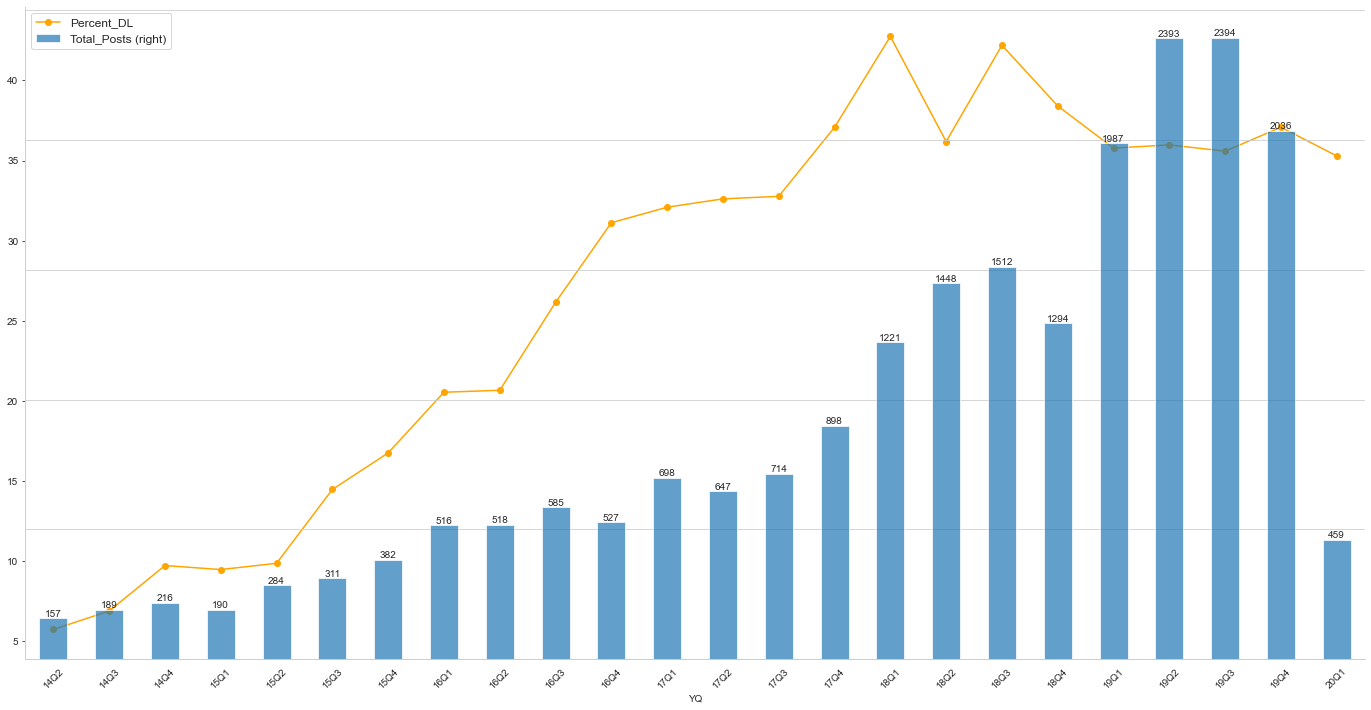

In [48]:
#plot percentage of deep learning posts and total posts to view trajectory of deep learning interest
#made with a lot of help and research

ax1 = over_years.plot(x="YQ", y="Percent_DL",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = over_years.plot(x="YQ", y="Total_Posts",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in over_years["Total_Posts"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})

for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

sns.set_style('dark')

Interest in deep learning has been steadily growing over the years, plateauing around 2019. However, it still appears to be a popular topic and would be a good choice for content.